Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Loading Parachute Cross Section Data...
Data loaded successfully.


--- Exploratory Data Analysis (EDA) ---

1. Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  212 non-null    int64         
 1   Disbursement Date                   212 non-null    datetime64[ns]
 2   Loan Status                         212 non-null    object        
 3   Loan Amount                         212 non-null    float64       
 4   Outstanding Balance                 212 non-null    float64       
 5   Outstanding Principal               212 non-null    float64       
 6   Interest Rate                       212 non-null    float64       
 7   Loan Term (Months)                  212 non-null    int64         
 8   Date of Birth                       2

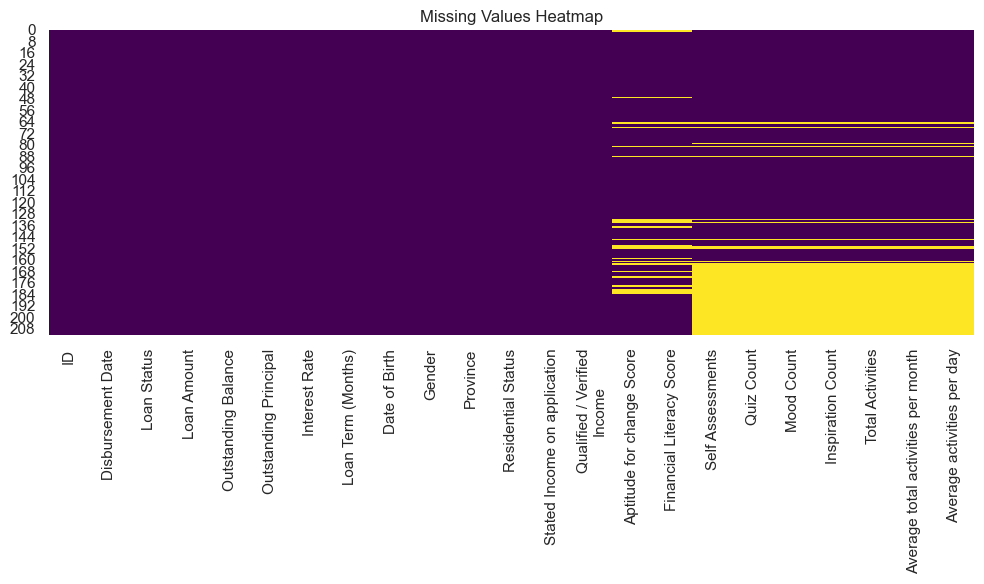

Missing values heatmap displayed.

4. Target Variable Distribution:
Target variable 'Repayment_Risk' not found. Skipping target distribution plot.

5. Numerical Features Distribution:


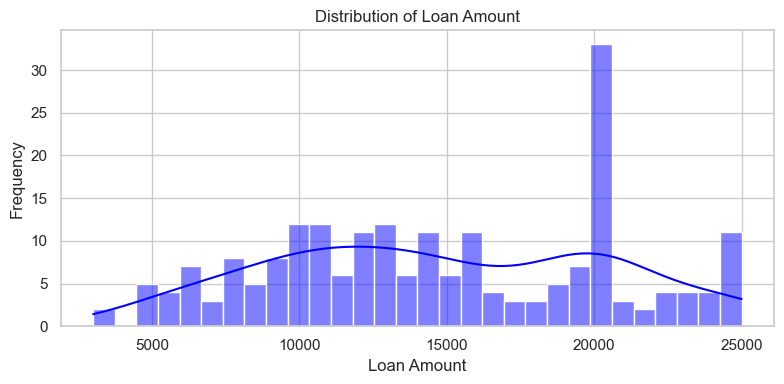

Distribution plot for 'Loan Amount' displayed.



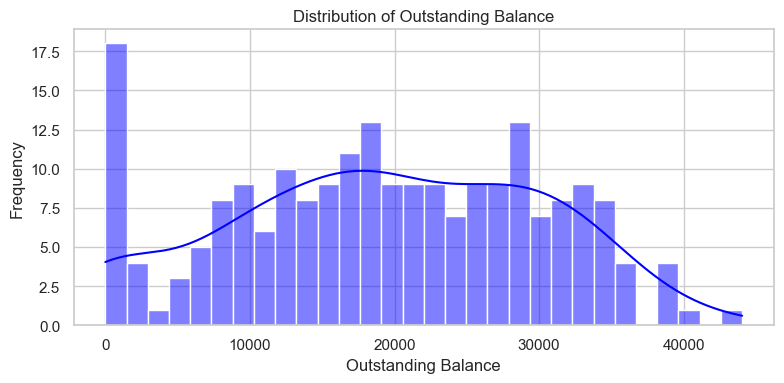

Distribution plot for 'Outstanding Balance' displayed.



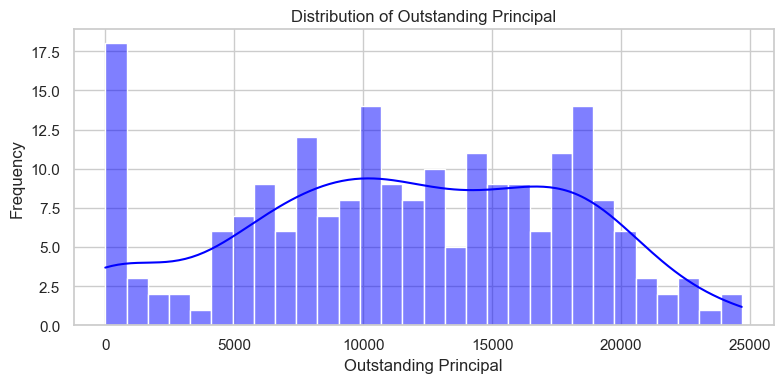

Distribution plot for 'Outstanding Principal' displayed.



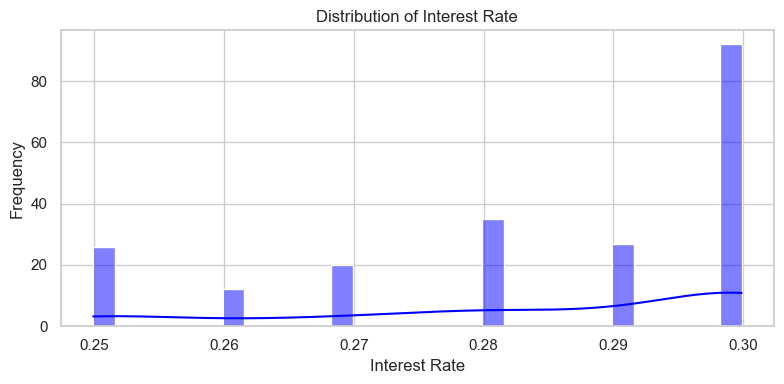

Distribution plot for 'Interest Rate' displayed.



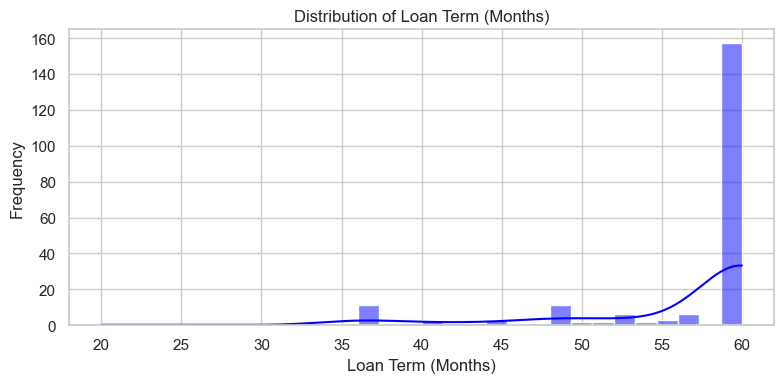

Distribution plot for 'Loan Term (Months)' displayed.



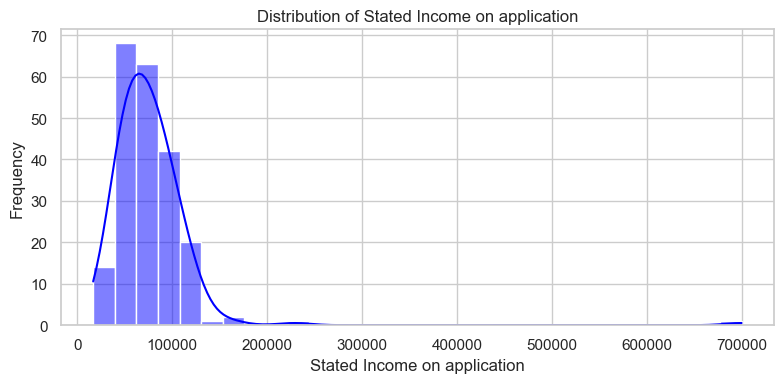

Distribution plot for 'Stated Income on application' displayed.



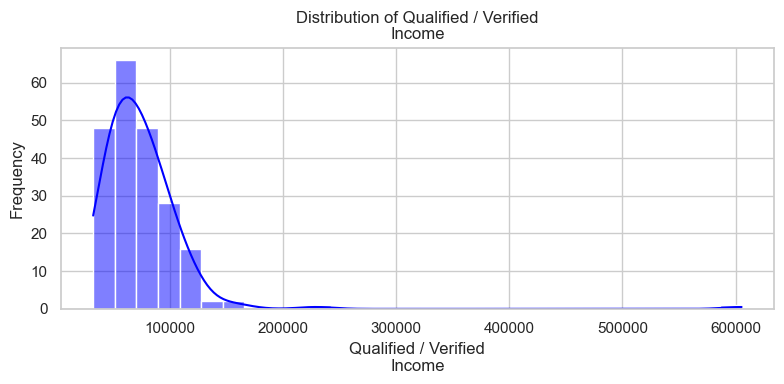

Distribution plot for 'Qualified / Verified
Income' displayed.



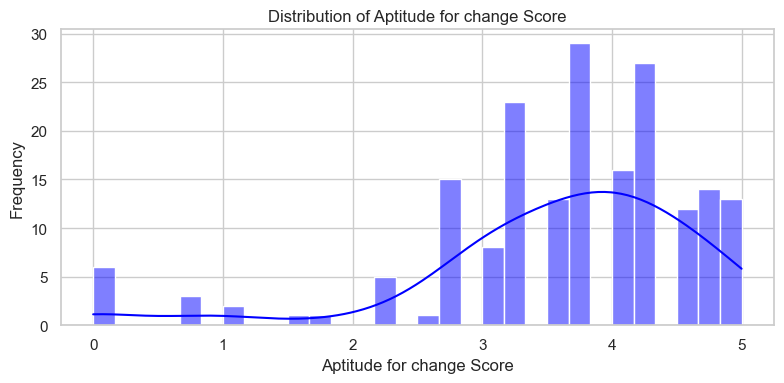

Distribution plot for 'Aptitude for change Score' displayed.



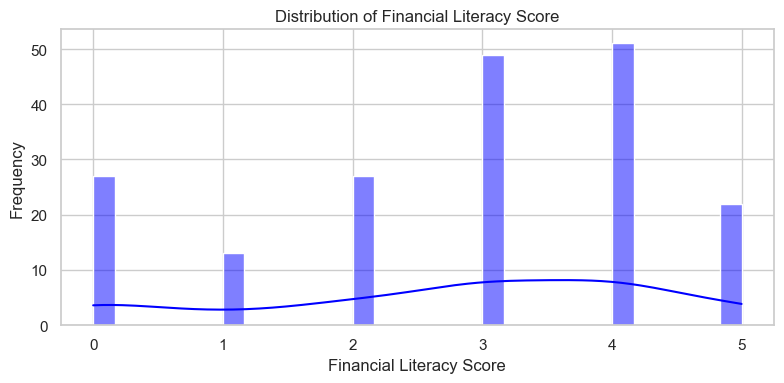

Distribution plot for 'Financial Literacy Score' displayed.



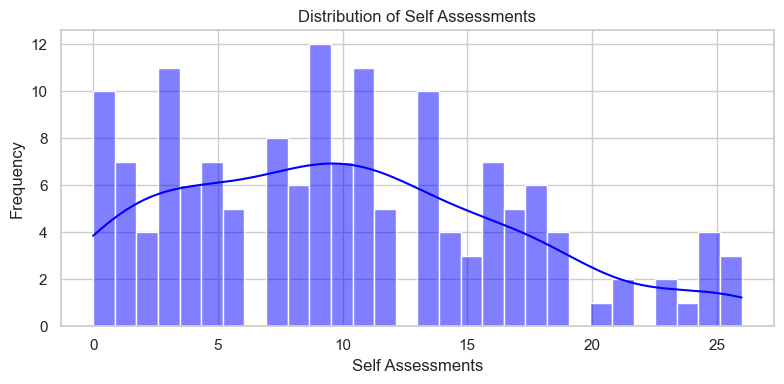

Distribution plot for 'Self Assessments' displayed.



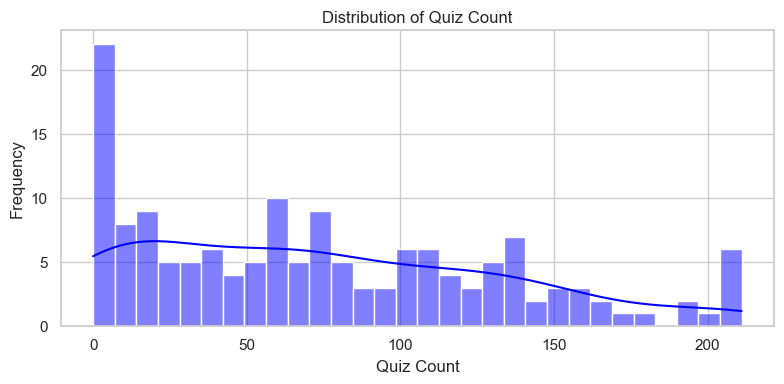

Distribution plot for 'Quiz Count' displayed.



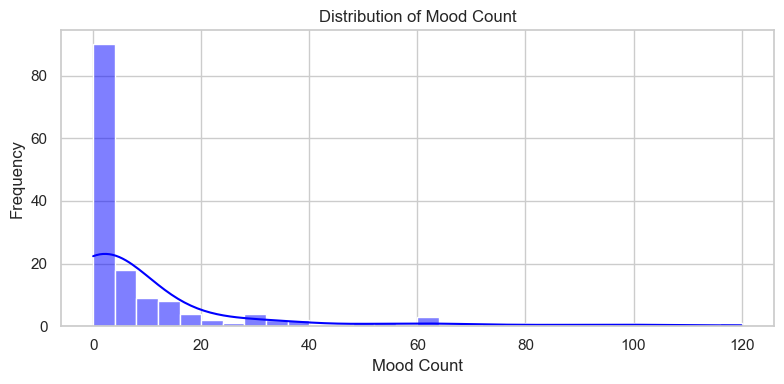

Distribution plot for 'Mood Count' displayed.



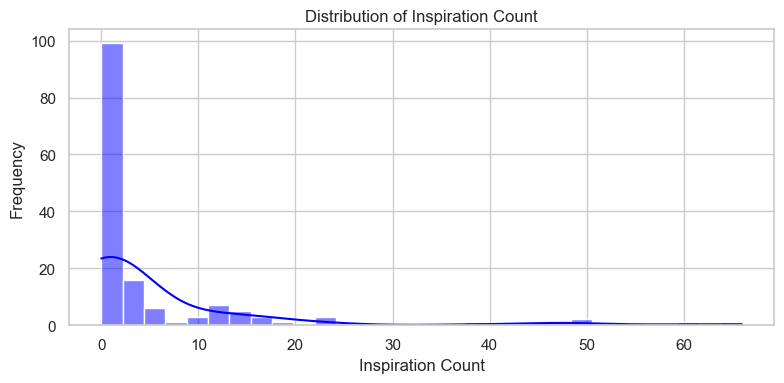

Distribution plot for 'Inspiration Count' displayed.



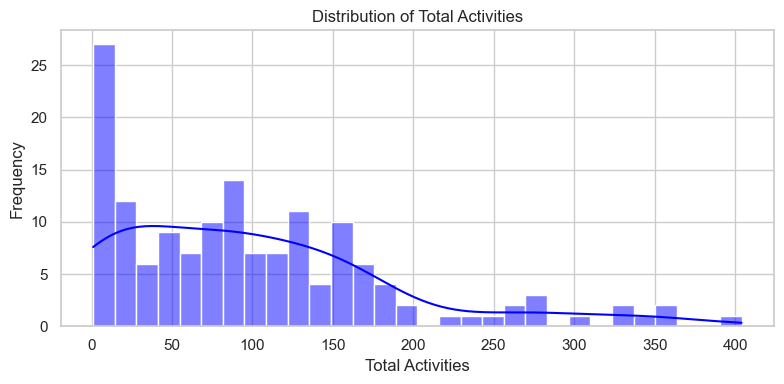

Distribution plot for 'Total Activities' displayed.



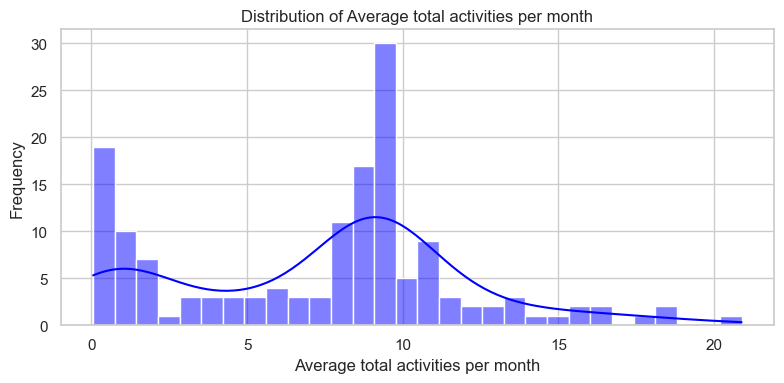

Distribution plot for 'Average total activities per month' displayed.



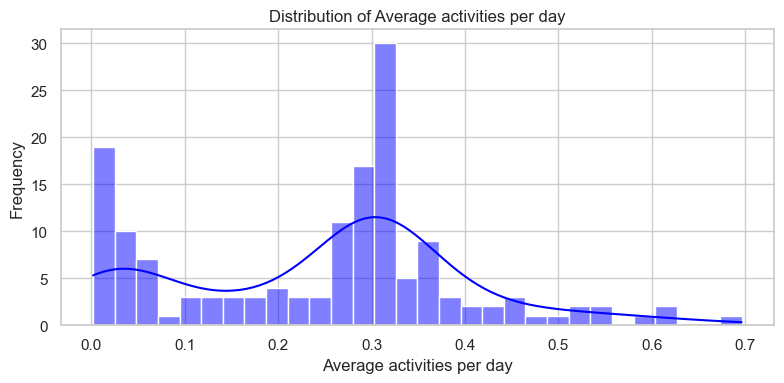

Distribution plot for 'Average activities per day' displayed.

6. Categorical Features Analysis:


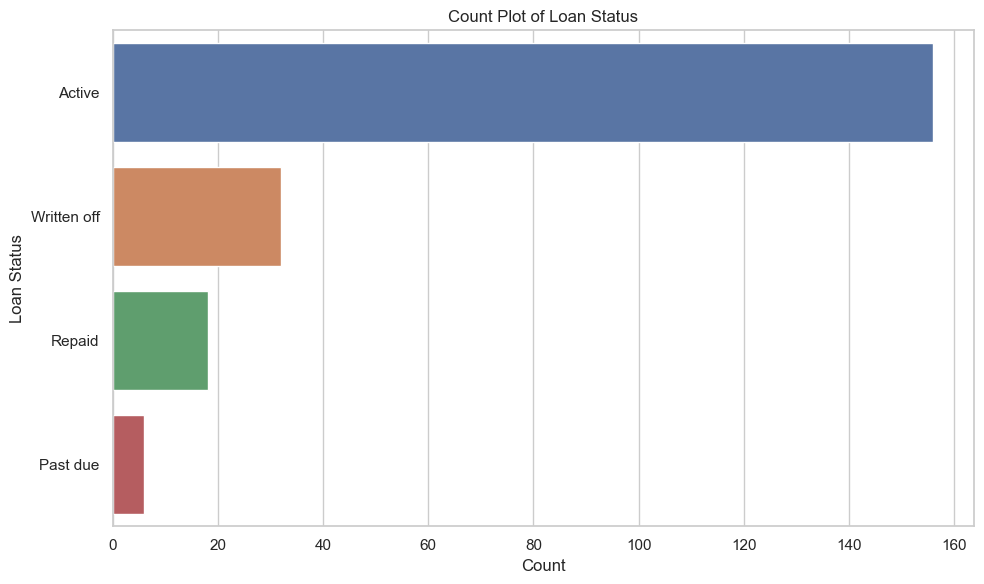

Count plot for 'Loan Status' displayed.



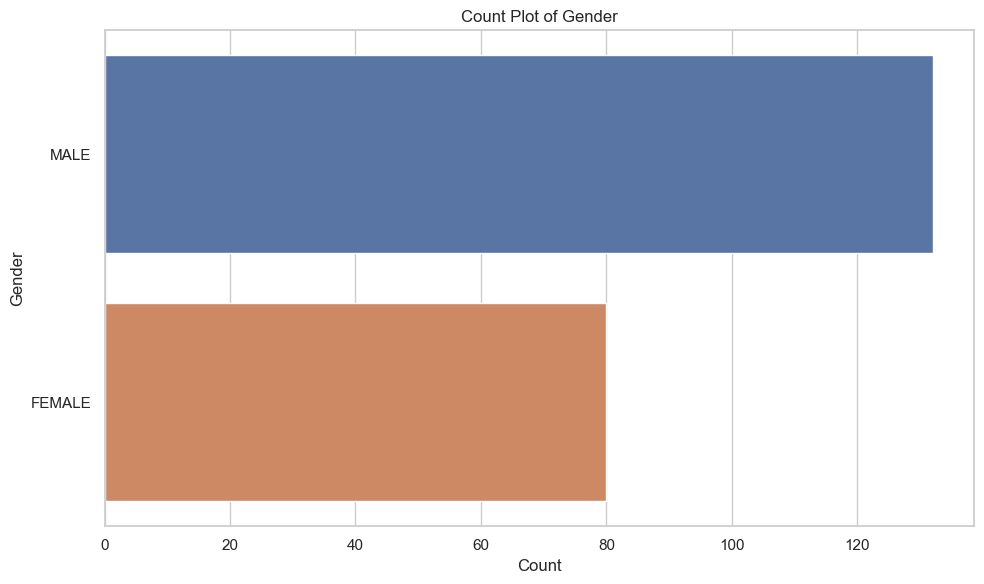

Count plot for 'Gender' displayed.



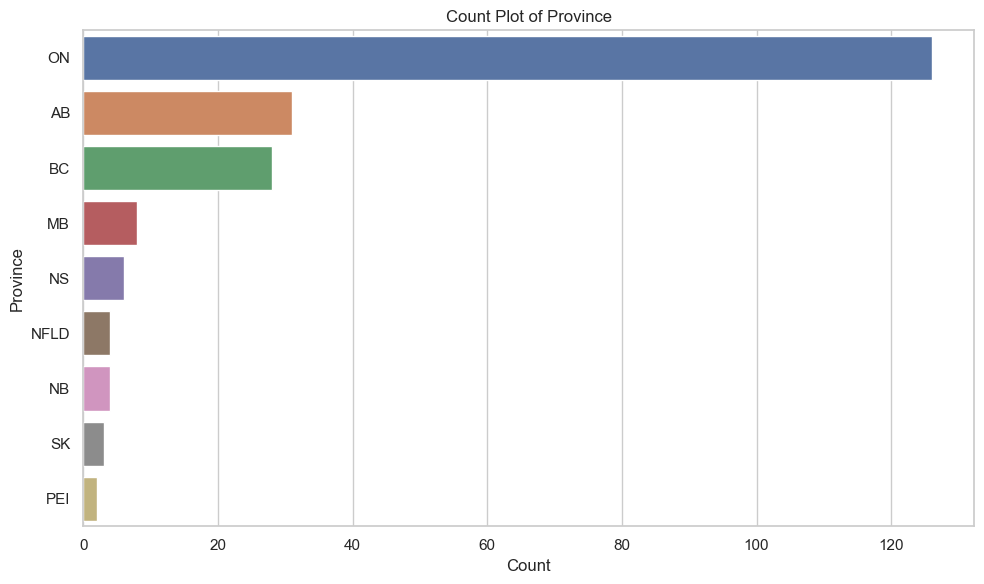

Count plot for 'Province' displayed.



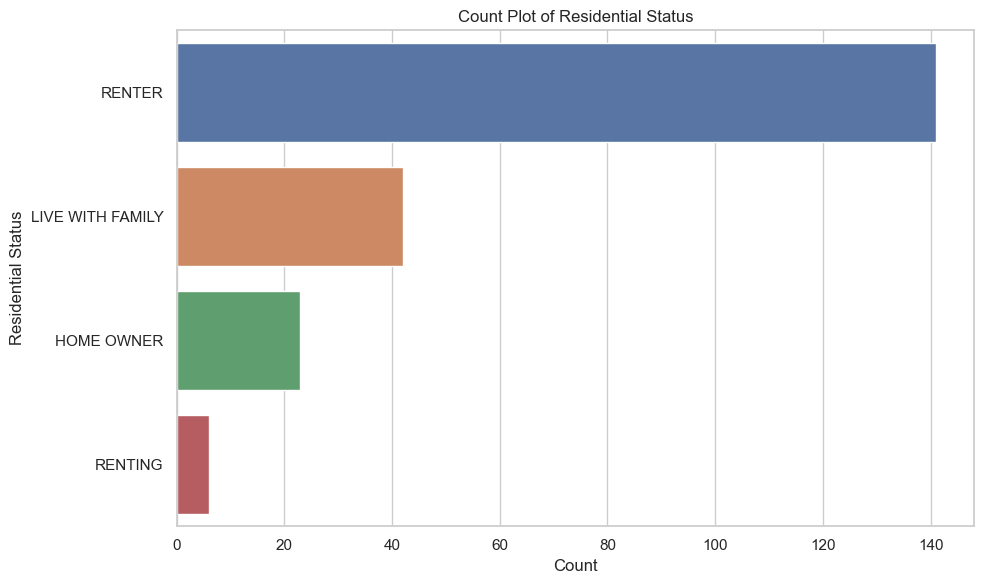

Count plot for 'Residential Status' displayed.

Target variable 'Repayment_Risk' not found. Skipping correlation with target analysis.

Creating financial features...
Financial features created successfully.

Validating features and identifying redundant ones...


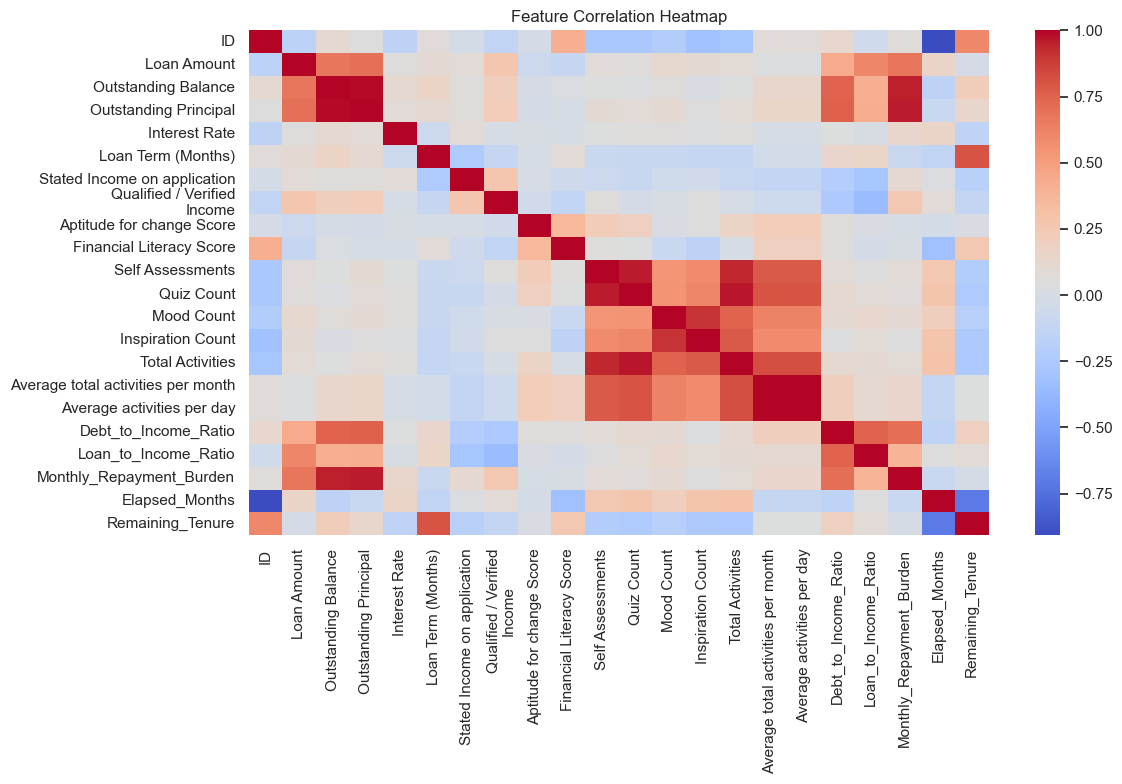

Feature correlation heatmap displayed.

Redundant features (correlation > 0.9): {'Quiz Count', 'Monthly_Repayment_Burden', 'Total Activities', 'Outstanding Principal', 'Elapsed_Months', 'Inspiration Count', 'Average activities per day'}

Dropped redundant features.

Merging with TransUnion data...
Data merged with TransUnion data successfully.

Creating credit-related features...


KeyError: 'revolving_credit_balance'

In [40]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Set plot style
sns.set(style='whitegrid')

OUTPUT_DIR = 'output_repayment_risk'
os.makedirs(OUTPUT_DIR, exist_ok=True)
CURRENT_YEAR = datetime.now().year

file_path = 'Input/Data 3 - October, 2024.xlsx'  # Replace with your actual file path
sheet_name = 'Parachute - Cross Section'          # Update with your sheet name

print("Loading Parachute Cross Section Data...")
df = pd.read_excel(file_path, sheet_name=sheet_name)
df.columns = df.columns.str.strip()

# Ensure necessary columns exist
required_columns = [
    'ID', 'Outstanding Principal', 'Qualified / Verified\nIncome', 
    'Loan Amount', 'Outstanding Balance', 'Loan Term (Months)'
]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")
print("Data loaded successfully.\n")

print("\n--- Exploratory Data Analysis (EDA) ---\n")

# 4.1. Basic Information
print("1. Dataset Information:")
print(df.info())
print("\n")

# 4.2. Summary Statistics
print("2. Summary Statistics:")
print(df.describe())
print("\n")

# 4.3. Missing Values Analysis
print("3. Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print("\n")

# Plot Missing Values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()
print("Missing values heatmap displayed.\n")

# 4.4. Target Variable Distribution
print("4. Target Variable Distribution:")
# Assuming 'Repayment_Risk' is not yet created; skip if not present
if 'Repayment_Risk' in df.columns:
    sns.countplot(x='Repayment_Risk', data=df)
    plt.title('Repayment Risk Distribution')
    plt.tight_layout()
    plt.show()
    print("Repayment risk distribution plot displayed.\n")
else:
    print("Target variable 'Repayment_Risk' not found. Skipping target distribution plot.\n")

# 4.5. Numerical Features Distribution
print("5. Numerical Features Distribution:")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['ID']]  # Exclude 'ID' if present

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    print(f"Distribution plot for '{col}' displayed.\n")

# 4.6. Categorical Features Analysis
print("6. Categorical Features Analysis:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Count Plot of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    print(f"Count plot for '{col}' displayed.\n")

# 4.7. Feature Correlation with Target
if 'Repayment_Risk' in df.columns:
    print("7. Feature Correlation with Target:")
    correlation_with_target = df.corr()['Repayment_Risk'].sort_values(ascending=False)
    print(correlation_with_target)
    print("\n")
    
    # Plot Correlation with Target
    plt.figure(figsize=(10, 8))
    sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
    plt.title('Feature Correlation with Repayment Risk')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print("Correlation with target plot displayed.\n")
else:
    print("Target variable 'Repayment_Risk' not found. Skipping correlation with target analysis.\n")
    
print("Creating financial features...")
# Avoid division by zero
df['Qualified / Verified\nIncome'].replace(0, np.nan, inplace=True)
df['Loan Term (Months)'].replace(0, np.nan, inplace=True)

# Financial Ratios
df['Debt_to_Income_Ratio'] = df['Outstanding Principal'] / df['Qualified / Verified\nIncome']
df['Loan_to_Income_Ratio'] = df['Loan Amount'] / df['Qualified / Verified\nIncome']
df['Monthly_Repayment_Burden'] = df['Outstanding Balance'] / df['Loan Term (Months)']

# Date Calculations
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
df['Age'] = CURRENT_YEAR - df['Date of Birth'].dt.year

df['Disbursement Date'] = pd.to_datetime(df['Disbursement Date'], errors='coerce')
df['Elapsed_Months'] = (datetime.now() - df['Disbursement Date']).dt.days // 30
df['Remaining_Tenure'] = df['Loan Term (Months)'] - df['Elapsed_Months']

# Handle infinite and missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

print("Financial features created successfully.\n")

print("Validating features and identifying redundant ones...")
# Select numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
correlation_matrix = numeric_df.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print("Feature correlation heatmap displayed.\n")

# Identify redundant features
redundant_features = set()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
for column in upper_triangle.columns:
    high_corr = upper_triangle[column].abs() > 0.9
    if high_corr.any():
        redundant_features.add(column)

print(f"Redundant features (correlation > 0.9): {redundant_features}\n")

# Drop redundant features
if redundant_features:
    df.drop(columns=list(redundant_features), inplace=True)
    print("Dropped redundant features.\n")
else:
    print("No redundant features found.\n")
    
sheet_name_trans_union = 'TU - Panel'  # Update if different

print("Merging with TransUnion data...")
trans_union_data = pd.read_excel(file_path, sheet_name=sheet_name_trans_union)
trans_union_data['disbursed_date'] = pd.to_datetime(trans_union_data['disbursed_date'], errors='coerce')

# Get the most recent disbursement date per loan_id
trans_union_data = trans_union_data.groupby('loan_id', as_index=False)['disbursed_date'].max()
trans_union_data['loan_id'] = trans_union_data['loan_id'].astype(str)
df['ID'] = df['ID'].astype(str)

df_merged = pd.merge(df, trans_union_data, left_on='ID', right_on='loan_id', how='left')

# Handle any new missing values after merge
df_merged.fillna(0, inplace=True)
print("Data merged with TransUnion data successfully.\n")

print("Creating credit-related features...")
# Avoid division by zero
credit_limit_cols = ['revolving_credit_limit', 'instalment_credit_limit']
for col in credit_limit_cols:
    if col in df_merged.columns:
        df_merged[col].replace(0, np.nan, inplace=True)

# Create credit-related features
df_merged['Total_Debt'] = df_merged['revolving_credit_balance'] + df_merged['instalment_credit_balance']
df_merged['Total_Credit_Limit'] = df_merged['revolving_credit_limit'] + df_merged['instalment_credit_limit']
df_merged['Debt_to_Credit_Ratio'] = df_merged['Total_Debt'] / df_merged['Total_Credit_Limit']
df_merged['Revolving_Utilization'] = df_merged['revolving_credit_balance'] / df_merged['revolving_credit_limit']
df_merged['Installment_Utilization'] = df_merged['instalment_credit_balance'] / df_merged['instalment_credit_limit']

# Handle infinite and missing values
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

print("Credit-related features created successfully.\n")

print("Validating credit features and identifying redundant ones...")
# Select numeric columns
numeric_df_credit = df_merged.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
correlation_matrix_credit = numeric_df_credit.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_credit, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Credit Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print("Credit feature correlation heatmap displayed.\n")

# Identify redundant credit features
redundant_credit_features = set()
upper_triangle_credit = correlation_matrix_credit.where(np.triu(np.ones(correlation_matrix_credit.shape), k=1).astype(bool))
for column in upper_triangle_credit.columns:
    high_corr = upper_triangle_credit[column].abs() > 0.9
    if high_corr.any():
        redundant_credit_features.add(column)

print(f"Redundant credit features (correlation > 0.9): {redundant_credit_features}\n")

# Drop redundant credit features
if redundant_credit_features:
    df_merged.drop(columns=list(redundant_credit_features), inplace=True)
    print("Dropped redundant credit features.\n")
else:
    print("No redundant credit features found.\n")
    
print("Deriving 'Repayment_Risk' feature...")
# Using a threshold for 'Debt_to_Credit_Ratio'
df_merged['Repayment_Risk'] = (df_merged['Debt_to_Credit_Ratio'] > 0.8).astype(int)
print("Unique values in 'Repayment_Risk' after encoding:", df_merged['Repayment_Risk'].unique())
print("Data type of 'Repayment_Risk' after encoding:", df_merged['Repayment_Risk'].dtype)
print("\n")

print("Preprocessing data...")
columns_to_remove = [
    'ID', 'Gender', 'Date of Birth', 'Disbursement Date', 'loan_id',
    'Loan Amount', 'Outstanding Balance', 'Outstanding Principal',
    'Loan Term (Months)', 'Stated Income on application',
    'Qualified / Verified\nIncome', 'Revolving_Utilization', 'Installment_Utilization'
]
df_encoded = df_merged.copy()

# Remove unnecessary columns
df_encoded.drop(columns=[col for col in columns_to_remove if col in df_encoded.columns], inplace=True)

# Drop columns with >50% missing values
df_encoded.dropna(thresh=len(df_encoded) * 0.5, axis=1, inplace=True)

# Handle missing values
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

if numeric_cols:
    imputer_num = SimpleImputer(strategy='median')
    df_encoded[numeric_cols] = imputer_num.fit_transform(df_encoded[numeric_cols])
    print("Missing values in numerical columns imputed with median.\n")

if categorical_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_encoded[categorical_cols] = imputer_cat.fit_transform(df_encoded[categorical_cols])
    print("Missing values in categorical columns imputed with most frequent value.\n")

# Encode categorical variables
if categorical_cols:
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
    print("Categorical variables encoded using one-hot encoding.\n")

# Scale numerical features
if numeric_cols:
    scaler = StandardScaler()
    df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
    print("Numerical features scaled using StandardScaler.\n")

print("Data preprocessing completed successfully.\n")

processed_output_path = os.path.join(OUTPUT_DIR, 'processed_repayment_data.xlsx')
df_encoded.to_excel(processed_output_path, index=False)
print(f"Processed repayment risk data saved to '{processed_output_path}'.\n")

print("Creating dataset for model...")
repayment_features = [
    'Debt_to_Credit_Ratio', 'Revolving_Utilization', 'Installment_Utilization',
    'Total_Debt', 'Total_Credit_Limit', 'fico_score', 'count_of_inquiries',
    'Debt_to_Income_Ratio', 'Monthly_Repayment_Burden', 'Loan_to_Income_Ratio'
]
repayment_features = [feat for feat in repayment_features if feat in df_encoded.columns]

if 'Repayment_Risk' in df_encoded.columns:
    # Include 'ID' in the dataset if it's still present
    if 'ID' in df_encoded.columns:
        repayment_data = df_encoded[['ID'] + repayment_features + ['Repayment_Risk']]
    else:
        repayment_data = df_encoded[repayment_features + ['Repayment_Risk']]
    output_path = os.path.join(OUTPUT_DIR, 'repayment_model_data.xlsx')
    repayment_data.to_excel(output_path, index=False)
    print(f"Repayment model data saved to '{output_path}'.\n")
else:
    print("Warning: 'Repayment_Risk' not found. Repayment model data not created.\n")


# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Visualization settings
%matplotlib inline
sns.set()

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 1. Load and Prepare Data9
# ----------------------------

print("Training and evaluating the repayment risk model...")

# Define OUTPUT_DIR if not already defined
# Replace 'path_to_output_dir' with your actual output directory
# Load the data
data_path = os.path.join(OUTPUT_DIR, 'repayment_model_data.xlsx')
data = pd.read_excel(data_path)

# Define features and target
repayment_features = [
    'Revolving_Utilization', 'Installment_Utilization',
    'fico_score', 'count_of_inquiries',
    'Monthly_Repayment_Burden', 'Loan_to_Income_Ratio'
]
# Ensure that all features exist in the data
repayment_features = [feat for feat in repayment_features if feat in data.columns]

X = data[repayment_features]
y = data['Repayment_Risk']

# ----------------------------
# 2. Data Preprocessing
# ----------------------------

# Ensure 'Repayment_Risk' is binary and integer
y = y.astype(int)
print("Unique values in 'Repayment_Risk':", y.unique())
print("Data type of 'Repayment_Risk':", y.dtype, "\n")

# ----------------------------
# 3. Train-Test Split
# ----------------------------

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Handle missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------------------------
# 4. Initialize and Train Classification Models
# ----------------------------

# Dictionary to store classification models
classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', n_estimators=200, random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=200, random_state=42
    ),
    'SVC': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42
    )
}

# Dictionary to store classification evaluation metrics
classification_performance = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC': []
}

# Train and Evaluate Classification Models
for model_name, model in classification_models.items():
    # Train the model
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Predict probabilities for AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models like SVC without predict_proba
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalize to [0,1]
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)
    
    # Store metrics
    classification_performance['Model'].append(model_name)
    classification_performance['Accuracy'].append(round(acc, 2))
    classification_performance['Precision'].append(round(prec, 2))
    classification_performance['Recall'].append(round(rec, 2))
    classification_performance['F1-Score'].append(round(f1, 2))
    classification_performance['AUC'].append(round(auc, 2))
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance for applicable models
    if model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Decision Tree']:
        importances = model.feature_importances_
        feature_names = repayment_features
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='magma')
        plt.title(f'Feature Importances from {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
        
    elif model_name == 'Logistic Regression':
        coefficients = model.coef_[0]
        feature_names = repayment_features
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        feature_importance_df['Importance'] = feature_importance_df['Coefficient'].abs()
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        sns.barplot(data=feature_importance_df, x='Coefficient', y='Feature', palette='coolwarm')
        plt.title('Feature Coefficients from Logistic Regression')
        plt.xlabel('Coefficient')
        plt.ylabel('Feature')
        plt.show()
    
    else:
        print(f"{model_name} does not provide straightforward feature importances.")
    
# ----------------------------
# 5. Compare Classification Model Performance
# ----------------------------

# Create a DataFrame to compare classification models
classification_performance_df = pd.DataFrame(classification_performance)

print("\nClassification Model Performance Comparison:")
print(classification_performance_df.sort_values(by='AUC', ascending=False))

# Visualize the performance
plt.figure(figsize=(12, 6))

# AUC Comparison
sns.barplot(data=classification_performance_df, x='Model', y='AUC', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('AUC Comparison')
plt.ylabel('AUC')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# ----------------------------
# 6. Cross-Validation for the Best Classification Model
# ----------------------------

# Identify the best classification model based on AUC
best_model_name = classification_performance_df.sort_values(by='AUC', ascending=False).iloc[0]['Model']
best_model = classification_models[best_model_name]

print(f"\nCross-Validation for {best_model_name}:")
cv_scores = cross_val_score(
    best_model, X_scaled, y, cv=5, scoring='roc_auc'
)
print("Cross-validated AUC scores:", cv_scores)
print("Average cross-validated AUC:", np.mean(cv_scores))

# ----------------------------
# 7. SHAP Values for Model Interpretability
# ----------------------------

import shap

if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    # SHAP values for tree-based models
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
    
    # Plot SHAP summary
    shap.summary_plot(shap_values, X_test, feature_names=repayment_features)
    
elif best_model_name == 'Logistic Regression':
    # SHAP values for linear models
    explainer = shap.LinearExplainer(best_model, X_train)
    shap_values = explainer.shap_values(X_test)
    
    # Plot SHAP summary
    shap.summary_plot(shap_values, X_test, feature_names=repayment_features)

# ----------------------------
# 8. Final Recommendations and Next Steps
# ----------------------------

print(f"\nBased on the AUC scores, the best model is {best_model_name}.")
print("Consider performing hyperparameter tuning on this model for potential improvements.")